In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.fft import fft, ifft
from scipy.optimize import line_search
from scipy.linalg import convolution_matrix
from PIL import Image, ImageOps
import time
import colorsys

<ipython-input-58-d3aacf00a068>:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(x0)


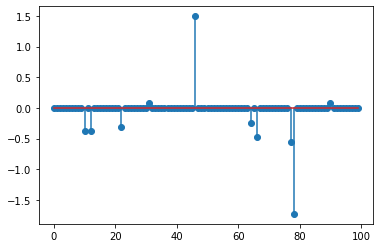

In [58]:
#Initializations
samples = 200;
features = 100;
A = np.random.randn(samples,features)
#Try different matrices
#y = np.random.randn(features)
#Initialize some random sparse solution
x0 = np.zeros((features,1))
p = np.random.permutation(features)
x0[p[:10]] = np.random.randn(10,1)
x0 = np.reshape(x0,-1)
y = A@x0
lam = .9 * np.max( np.abs(A.T @ y))
plt.stem(x0)
plt.show()

samples_t = 50
A_test = np.random.randn(samples_t,features)
y_test = A_test@x0 

#Create array of regularization parameters
#lamb = np.array([np.max(np.abs(A.T@y))/50,np.max(np.abs(A.T@y))/10, np.max(np.abs(A.T@y))/2, np.max(np.abs(A.T@y))])
lamb = np.array([np.max(np.abs(A.T@y))/50,np.max(np.abs(A.T@y))/25,np.max(np.abs(A.T@y))/10])
lamsz = np.size(lamb)

In [95]:
v = np.random.randn(features)*0.0001

#Helper function for calculating the Hessian of (1/lamda)*|A(u*v)-y|_2^2 + |u|_2^2 w.r.t u.
#Set s = 1 for an unbiased sample of the Hessian.
def gnabUU(v,A,y,lam,s):
    n = np.size(v)
    if (s == 1):
        m = np.size(A,0)
        rindx = np.random.randint(m)
        return np.eye(n) + m*(1/lam)*(np.diag(v) @ (np.outer(A[rindx,:],A[rindx,:]) @ np.diag(v)))
        #return lam*np.eye(n) + (np.diag(v) @ (np.outer(A,A) @ np.diag(v)))
    return np.eye(n) + (1/lam)*((np.diag(v) @ A.T) @ (A @ np.diag(v)))
    #return lam*np.eye(n) + ((np.diag(v) @ A.T) @ (A @ np.diag(v)))
    

#The Hessian Inverse Neumann approximation (deterministic)
def Hinv_neumann_dir(v,A,lam,b):
    Hess = gnabUU(v,A,y,lam,0)
    m = np.size(A,0)
    n = np.size(A,1)
    inv_hess_vals = np.zeros((b,n,n))
    Lg = np.linalg.norm(Hess,2)
    normed = (1/Lg)*Hess
    #print(np.linalg.norm(normed,2))
    out = (1/Lg)*np.eye(n)
    for i in range(b):
        out = np.eye(n) + (np.eye(n) - normed) @ out
        inv_hess_vals[i,:,:] = out
        
    return out,  inv_hess_vals

#The Hessian Inverse Approximation subroutine from Ghadimi
def Hinv_neumann(v,A,lam,b):
    m = np.size(A,0)
    n = np.size(A,1)
    p = np.random.randint(b)
    inv_hess_vals = np.zeros((p,n,n))
    print('p is ', p)
    Hess = np.eye(n) + (1/lam)*((np.diag(v) @ A.T) @ (A @ np.diag(v)))
    Lg = np.linalg.norm(Hess,2)
    out = (b/Lg)*np.eye(n)
    #print(np.linalg.norm(out,2))
    if (p == 0):
        return out
    for i in range(p):
        HessS = gnabUU(v,A,y,lam,1)
        out = out @ (np.eye(n) - (1/Lg)*HessS)
        inv_hess_vals[i,:,:] = out
        #print(np.linalg.norm(out,2))
        
    return out, inv_hess_vals

#Hessian Inverse Approximation as seen in the LiSSA algorithm
def Hinv_neumannV2(v,A,lam,b):
    
    #p = np.random.randint(b)
    #print('p is ', p)
    Hess = gnabUU(v,A,y,lam,0)
    m = np.size(A,0)
    n = np.size(A,1)
    inv_hess_vals = np.zeros((b,n,n))
    Lg = np.linalg.norm(Hess,2)
    out = (1/Lg)*np.eye(n)
    #print(np.linalg.norm(out,2))
    #if (p == 0):
        #return out
    for i in range(b):
        HessS = gnabUU(v,A,y,lam,1)
        out = np.eye(n) + (np.eye(n) - (1/Lg)*HessS) @ out
        inv_hess_vals[i,:,:] = out
        #print(np.linalg.norm(out,2))
        
    return out, inv_hess_vals

#SVRG-QUAD - Using the square-loss problem parameter A, we solve Hess * x = z for some z.
#This rendition is for the Hessian of a ridge-regularized problem
def SVRG_QUAD_reg(A,v,lam,z,T,eta):
    samples = np.size(A,0)
    features = np.size(A,1)
    m = 2*samples
    xvals = np.zeros((T*m,features))
    fvals = np.zeros(T*m)
    x = np.random.randn(features)*0.0001
    H = np.eye(features) + (1/lam)*((np.diag(v) @ A.T) @ (A @ np.diag(v)))
    for i in range(T):
        gradA = H @ x - z
        x0 = x
        for j in range(m):
            rindx = np.random.randint(samples)
            Aind = A[rindx,:]
            vAind = np.diag(v) @ Aind
            Hind = np.eye(features) + samples*(1/lam)*np.outer(vAind,vAind)
            gradAi = Hind @ x - z
            gradAix0 = Hind @ x0 - z
            x = x - eta*(gradAi - gradAix0 + gradA)
            #print(np.linalg.norm(x,2))
            xvals[i*m + j,:] = x
            fvals[i*m + j] = np.inner(x,H @ x)/2 - np.inner(x,z)
    
    return xvals, fvals
    #return xvals[-1,:]

In [93]:
#Here we check that our sampling of the inverse Hessian is correct
H1 = np.linalg.inv(gnabUU(v,A,y,lam,0))
#Deterministic Neumann series
H2, ihv2 = Hinv_neumann_dir(v,A,lam,1000)
#Ghadimi's method
H3, ihv3 = Hinv_neumann(v,A,lam,1000)
#LiSSA's method
H4, ihv4 = Hinv_neumannV2(v,A,lam,1000)
print('The relative error between deterministic Neumann series and true Hessian is', np.linalg.norm(H1 - H2,2)/np.linalg.norm(H1,2))
print('The relative error between ghadimis sampled Hessian and true Hessian is', np.linalg.norm(H1 - H3,2)/np.linalg.norm(H1,2))
print('The relative error between LiSSAs sampled Hessian and true Hessian is', np.linalg.norm(H1 - H4,2)/np.linalg.norm(H1,2))

p is  418
The relative error between deterministic Neumann series and true Hessian is 5.129736750772332e-08
The relative error between ghadimis sampled Hessian and true Hessian is 1.0
The relative error between LiSSAs sampled Hessian and true Hessian is 4.6299668886754126e-07


p is  775
The relative error between ghadimis sampled Hessian and true Hessian is 0.0009140979777449696
The relative error between LiSSAs sampled Hessian and true Hessian is 8.539761182355391e-11
The relative error between SVRG-QUAD sampled Hessian and true Hessian is 1.2387960497607313e-11


<ipython-input-94-b22e8f87b199>:39: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axs[0,0].stem(true_vec)
<ipython-input-94-b22e8f87b199>:41: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axs[0,1].stem(xvals1[-1,:])
<ipython-input-94-b22e8f87b199>:43: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour

Text(0.5, 1.0, 'Compare convergence of stochastic methods')

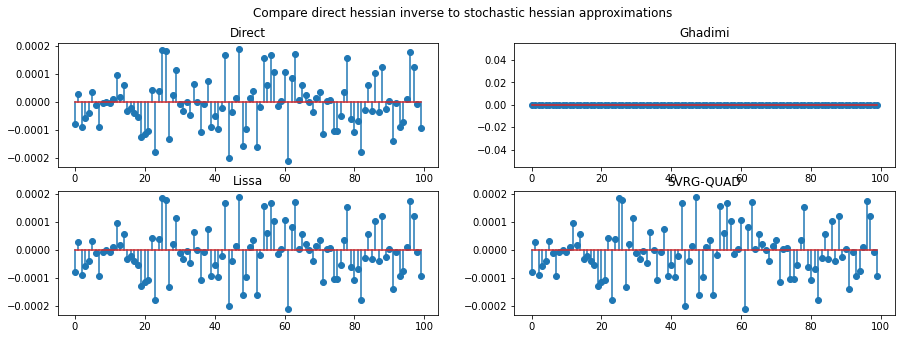

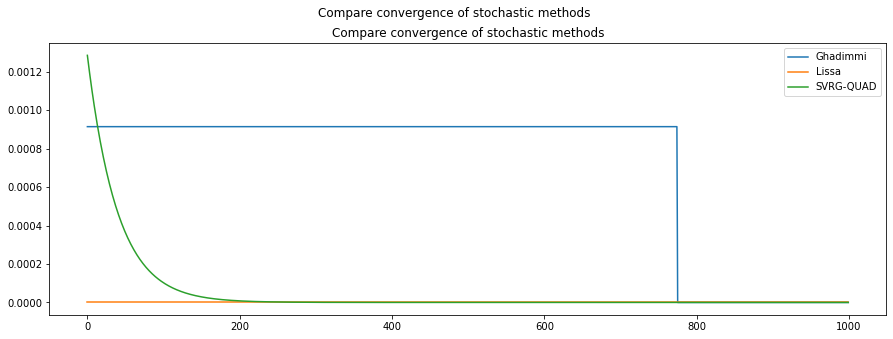

In [94]:
#Comparing calculation of x = H^-1 * z
#Use 1000 steps in each calculation
y_testing = np.random.randn(features)*0.0001
inv_test = np.linalg.inv(gnabUU(v,A,y,lam,0))
true_vec = inv_test @ y_testing

k = 1000

err_vals1 = np.zeros(1000)
err_vals2 = np.zeros(1000)
err_vals3 = np.zeros(1000)

v = np.random.randn(features)*0.0001

inv_test_ghadimi, inv_Hvals_ghad = Hinv_neumann(v,A,lam,1000)
inv_test_lissa, inv_Hvals_lissa = Hinv_neumannV2(v,A,lam,1000)
inv_test_quad, inv_Hvals_quad = SVRG_QUAD_reg(A,v,lam,y_testing,5,0.025)

p = np.size(inv_Hvals_ghad,0)

xvals1 = np.zeros((p,features))
xvals2 = np.zeros((k,features))
xvals3 = inv_test_quad
for i in range(k):
    if (i < p):
        xvals1[i,:] = inv_Hvals_ghad[i,:,:] @ y_testing
        err_vals1[i] = np.linalg.norm(xvals1[i,:] - true_vec,2)
    
    xvals2[i,:] = inv_Hvals_lissa[i,:,:] @ y_testing
    err_vals2[i] = np.linalg.norm(xvals2[i,:] - true_vec,2)
    err_vals3[i] = np.linalg.norm(xvals3[i,:] - true_vec,2)
    

print('The relative error between ghadimis sampled Hessian and true Hessian is',np.linalg.norm(true_vec - xvals1[-1,:],2)/np.linalg.norm(inv_test,2))
print('The relative error between LiSSAs sampled Hessian and true Hessian is',np.linalg.norm(true_vec - xvals2[-1,:],2)/np.linalg.norm(inv_test,2))
print('The relative error between SVRG-QUAD sampled Hessian and true Hessian is',np.linalg.norm(true_vec - inv_test_quad[-1,:],2)/np.linalg.norm(inv_test,2))
fig, axs = plt.subplots(2,2, figsize=(15,5))
fig.suptitle('Compare direct hessian inverse to stochastic hessian approximations')
axs[0,0].stem(true_vec)
axs[0,0].set_title('Direct')
axs[0,1].stem(xvals1[-1,:])
axs[0,1].set_title('Ghadimi')
axs[1,0].stem(xvals2[-1,:])
axs[1,0].set_title('Lissa')
axs[1,1].stem(inv_test_quad[-1,:])
axs[1,1].set_title('SVRG-QUAD')

fig, axs2 = plt.subplots(1,1, figsize=(15,5))
fig.suptitle('Compare convergence of stochastic methods')
axs2.plot(err_vals1, label = 'Ghadimmi')
axs2.plot(err_vals2, label = 'Lissa')
axs2.plot(err_vals3, label = 'SVRG-QUAD')
axs2.legend()
axs2.set_title('Compare convergence of stochastic methods')
